In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import tensorflow as tf


def plotAccuracies(history):
    x = range(1, len(history['sparse_categorical_accuracy']) + 1)
    trainingAcc = history['sparse_categorical_accuracy']
    validationAcc = history['val_sparse_categorical_accuracy']
    plt.plot(x, trainingAcc, 'b', label='Training accuracy')
    plt.plot(x, validationAcc, 'r', label='Validation accuracy')
    plt.title('Accuracy (Training and validation)')
    plt.xlabel('epoch')
    plt.legend()
    

def plotLosses(history):
    x = range(1, len(history['loss']) + 1)
    trainingLoss =  history['loss']
    validationLoss = history['val_loss']
    plt.plot(x, trainingLoss, 'b', label='Training loss')
    plt.plot(x, validationLoss, 'r', label='Validation loss')
    plt.title('Losses (Training and validation)')
    plt.xlabel('epoch')
    plt.legend()


# Plot history of nn fit
def plot_history_loss(history, model_name):
    x = range(1, len(history["loss"])+1)

    plt.figure()
    plt.plot(x, history["loss"], 'b-', label='Training loss')
    plt.plot(x, history["val_loss"], 'g-', label='Validation loss')
    plt.title('Training and validation Losses '+'-'+model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Categorical Cross-Entropy)')
    plt.xticks(x, range(1, len(history["loss"])+1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
import os
print(tf.__version__)

2.9.1


#Sinais com tamanho fixo (feed forward)

In [ ]:
#So da p sinal fixo
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.layers import UpSampling1D, Conv1D, Input, LeakyReLU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers


def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

def funcaoCortar(x):
    N = tf.shape(x)[1] #
    inicioRandom = tf.random.uniform([], maxval= N - 2000, dtype=tf.int32)
    novoSinal = x[:,tf.maximum(0,N-inicioRandom-2000):N-inicioRandom]
    return novoSinal

################################################################################################
############################################# Validacao #########################################
dirValidacao = './Novos Ficheiros/validacaoAlunos/'
list_npy_filesValidacao = glob.glob(dirValidacao + '*.npy')
fnames_datasetValidacao = tf.data.Dataset.from_tensor_slices(list_npy_filesValidacao)

itValidacao = iter(fnames_datasetValidacao)
exValidacao = next(itValidacao)
print(exValidacao)

#faz overlap pelo meio para apanhar o que nao conhecemos
#aplicar transformada fourier
datasetValidacao = fnames_datasetValidacao.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(funcaoCortar).map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))

#feedforward p segmentar
batch_size = 64
dataset3Validacao = datasetValidacao.batch(batch_size)
it3Validacao = iter(dataset3Validacao)
ex3Validacao = next(it3Validacao)
print(ex3Validacao[0].shape)
print(ex3Validacao[1].shape)

################################################################################################
################################################ Treino ########################################
dirTreino = './Novos Ficheiros/trainAlunos/'
list_npy_filesTreino = glob.glob(dirTreino + '*.npy')
fnames_datasetTreino = tf.data.Dataset.from_tensor_slices(list_npy_filesTreino)

itTreino= iter(fnames_datasetTreino)
exTreino = next(itTreino)
print(exTreino)


datasetTreino = fnames_datasetTreino.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(funcaoCortar).map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))


batch_size = 64
dataset3Treino = datasetTreino.batch(batch_size)
it3Treino = iter(dataset3Treino)
ex3Treino = next(it3Treino)
print(ex3Treino[0].shape)
print(ex3Treino[1].shape)

################################################################################################


def create_model():
    #se aplicarmos a batch normalization antes do relu, o relu vai po los nao standardizado
    model = Sequential()
    model.add(keras.Input(shape=(14,129)))
    model.add(Flatten())
    #estava 4
    model.add(Dense(64, input_shape = (14, 129)))
    model.add(Activation("leaky_relu"))
    model.add(BatchNormalization())

    model.add(Dense(64, input_shape = (14, 129)))
    model.add(Activation("leaky_relu"))
    model.add(BatchNormalization())

    model.add(Dense(1000))
    model.add(Reshape((200,5)))
    model.add(UpSampling1D(size=10))
    model.add(Activation("softmax"))
    
    return model



def execKerasSequencial(datasetTreino, datasetValidacao):
    print("########## \n KERAS SEQUENCIAL \n##########")

    NUM_EPOCHS = 100

    opt = Adam()
    model = create_model()
    model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=["sparse_categorical_accuracy"])
    model.summary()
    history = model.fit(datasetTreino, validation_data = datasetValidacao, epochs=NUM_EPOCHS)
    return history, model


modeloFeedForwardHistorico, modeloFeedForward = execKerasSequencial(dataset3Treino, dataset3Validacao)


In [ ]:
# Erros de treino e validacao
plotLosses(modeloFeedForwardHistorico.history)
plt.figure()
plotAccuracies(modeloFeedForwardHistorico.history)

## Estimar o erro e accuracy de teste (percorrer todos os ficheiros de teste e fazer uma média dos valores de erro e accuracy)

In [ ]:
#Teste (previsao)
import os

dirTeste = './testeAlunos/testeAlunos/'
list_npy_filesTeste = glob.glob(dirTeste + '*.npy')
fnames_datasetTeste = tf.data.Dataset.from_tensor_slices(list_npy_filesTeste)
datasetTesteEvaluate = fnames_datasetTeste.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(funcaoCortar).map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))
batch_size = 1
dataset3Teste = datasetTesteEvaluate.batch(batch_size)


allLosses = []
allAccuracies = []
for file in os.listdir(dirTeste):
    filename = os.fsdecode(file)
    readNumpy = np.load(dirTeste + filename)
    readNumpyXs = readNumpy[0]
    splitedSize = 2000
    splitNumpy = [readNumpyXs[x:x+splitedSize] for x in range(0, len(readNumpyXs), splitedSize)]
    splitNumpy[-1] = np.append(splitNumpy[-1], np.zeros(splitedSize-len(splitNumpy[-1])))

    arrayFinal = []
    for i in splitNumpy:
        arrayFinal.append( tf.math.abs(tf.signal.stft(i, 256, 128)))

    batchExemplos = np.array(arrayFinal)
    prediction = modeloFeedForward.predict(batchExemplos)

    predictionArgMax = tf.argmax(prediction, axis=-1)
    #print(predictionArgMax)
    #um array para cada segmento (com tamanho 2000) e dentro desse array de 2000, um valor da classe para cada ponto
    #previsao da classe para cada ponto do sinal
    #print(tf.shape(prediction))
    #print(readNumpy[1])

    desenrolarPredictionArgMax = tf.reshape(prediction, (-1, 5))
    # print(len(desenrolarPredictionArgMax))
    # print(len(readNumpy[1]))

    diferencaTamanho = len(desenrolarPredictionArgMax) - len(readNumpy[1])
    print(diferencaTamanho)
    if diferencaTamanho != 0:
         desenrolarPredictionArgMax = desenrolarPredictionArgMax[:-diferencaTamanho]


    metricas = tf.keras.metrics.sparse_categorical_accuracy(readNumpy[1], desenrolarPredictionArgMax)
    
    datasetTesteEvaluate = fnames_datasetTeste.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(funcaoCortar).map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))
    batch_size = 1
    datasetTesteEvaluate = datasetTesteEvaluate.batch(batch_size)
    #loss e accuracy
    loss, accuracy = modeloFeedForward.evaluate(datasetTesteEvaluate)
    allLosses.append(loss)
    allAccuracies.append(accuracy)
    print(loss, accuracy)

print("Numero de ficheiros de teste: ", len(os.listdir(dirTeste)))
print("Loss Média: ", np.mean(allLosses))
print("Accuracy Média: ", np.mean(allAccuracies))



Cause: could not parse the source code of <function <lambda> at 0x0000022B32FE13A0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000022B32FE13A0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.au

## Prever 1 ficheiro individual numpy

tf.Tensor(
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 4 4 4]], shape=(14, 2000), dtype=int64)
tf.Tensor([  14 2000    5], shape=(3,), dtype=int32)
[4. 4. 4. ... 3. 3. 3.]
(28000, 5)
28000
27107
893


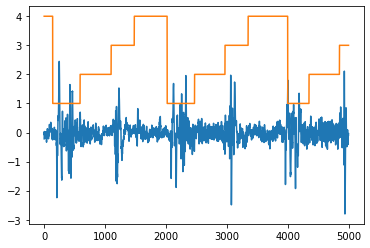

In [ ]:
def predictNumpy(readNumpyXs):
    #print(readNumpy)
    splitedSize = 2000
    splitNumpy = [readNumpyXs[x:x+splitedSize] for x in range(0, len(readNumpyXs), splitedSize)]
    splitNumpy[-1] = np.append(splitNumpy[-1], np.zeros(splitedSize-len(splitNumpy[-1])))

    arrayFinal = []
    for i in splitNumpy:
        arrayFinal.append( tf.math.abs(tf.signal.stft(i, 256, 128)))

    batchExemplos = np.array(arrayFinal)
    prediction = modeloFeedForward.predict(batchExemplos)

    desenrolarPredictionArgMax = tf.reshape(prediction, (-1, 5))
    # print(np.shape(desenrolarPredictionArgMax))
    # print(len(desenrolarPredictionArgMax))
    # print(len(readNumpy[1]))

    diferencaTamanho = len(desenrolarPredictionArgMax) - len(readNumpy[1])
    print(diferencaTamanho)
    if diferencaTamanho != 0:
            desenrolarPredictionArgMax = desenrolarPredictionArgMax[:-diferencaTamanho]

    return desenrolarPredictionArgMax


#Testar com um ficheiro exemplo (de teste)
filename = "38337_MV_sigTarg.npy"
readNumpy = np.load(dirTeste + filename)
readNumpyAtribs = readNumpy[0]

previsao = predictNumpy(readNumpyAtribs)
previsaoArgMax = tf.argmax(previsao, axis=-1)
plt.plot(readNumpyAtribs[:5000]/2000)
plt.plot(previsaoArgMax[:5000])

## Sinais com tamanho variavel convolutional

In [137]:
#https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
#Ordem batch normalization, relu...
#-> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->#

from tensorflow.keras.layers import UpSampling1D, Conv1D, Input, LeakyReLU
from tensorflow.keras.models import Model
import glob
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling1D, Conv1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, TimeDistributed, SpatialDropout1D, Softmax
from tensorflow import keras
from tensorflow.keras import layers



def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)


################################## Validacao ###############################
dirValidacao = './Novos Ficheiros/validacaoAlunos/'

list_npy_filesValidacao = glob.glob(dirValidacao + '*.npy')
fnames_datasetValidacao = tf.data.Dataset.from_tensor_slices(list_npy_filesValidacao)
# itValidacao = iter(fnames_datasetValidacao)
# exValidacao = next(itValidacao)
# print(exValidacao)

#faz overlap pelo meio para apanhar o que nao conhecemos
#aplicar transformada fourier
datasetValidacao = fnames_datasetValidacao.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Validacao = datasetValidacao.padded_batch(batch_size, shapes)
# it3Validacao = iter(dataset3Validacao)
# ex3Validacao = next(it3Validacao)
# print(ex3Validacao)

#############################################################################
################################## Treino ###################################
dirTreino = './Novos Ficheiros/trainAlunos/'
list_npy_filesTreino = glob.glob(dirTreino + '*.npy')
fnames_datasetTreino = tf.data.Dataset.from_tensor_slices(list_npy_filesTreino)
# itTreino = iter(fnames_datasetTreino)
# exTreino = next(itTreino)
# print(exTreino)

datasetTreino = fnames_datasetTreino.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))

batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Treino = datasetTreino.padded_batch(batch_size, shapes)
it3Treino = iter(dataset3Treino)
ex3Treino = next(it3Treino)
print(ex3Treino)

#############################################################################
######### Definir rede #########

#Escalar com o tamanho do sinal
input1 = Input(shape=[], name='input1')
#Vetor do sinal propriamente dito (da short time fourier transform)
input2 = Input(shape=(None, 33) ,name='input2')


layer = Conv1D(64, 5, padding="same")(input2)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(2)(layer)

layer = Conv1D(64, 5, padding="same")(layer)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(2)(layer)

layer = Conv1D(64, 5, padding = "same")(layer)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(2)(layer)


layer = Conv1D(128, 5, padding = "same")(layer)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(2)(layer)


# ############ Para testar e ver os shapes das coisas #############
# functionalKerasModel = Model(inputs = [input1,input2], outputs = layer)  
# o = functionalKerasModel(ex3Treino[0])
# # (256, 43, 128)
# # (256, 49680)
# print(o.shape) #(1, 197, 32) (1, 373, 128)
# print(ex3Treino[1].shape) #(1, 25435) (1, 47997)
#################################################################

p = 35
layer = TimeDistributed(Dense(p))(layer)
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=78)(layer) #12

#Cortar pelo L
L = tf.reduce_max(input1)
L = tf.cast(L, tf.int32)
output = layer[:,:L] #queremos cortar pelo tamnho L para todos os exemplos do batch
layer = Activation("softmax")(output)

ConvVariavelModel = Model(inputs = [input1,input2], outputs = layer)   
ConvVariavelModel.summary()

NUM_EPOCHS = 50
opt = Adam()

from keras.callbacks import EarlyStopping 
early_stopping_monitor = EarlyStopping(patience=50) 

ConvVariavelModel.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt , metrics=["sparse_categorical_accuracy"])
ConvVarModelHistorico = ConvVariavelModel.fit(dataset3Treino, validation_data = dataset3Validacao, epochs=NUM_EPOCHS, callbacks=[early_stopping_monitor])


tf.Tensor(b'./Novos Ficheiros/validacaoAlunos\\14998_PV_sigTarg.npy', shape=(), dtype=string)
Cause: could not parse the source code of <function <lambda> at 0x000002A287F1E940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002A287F1E940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])


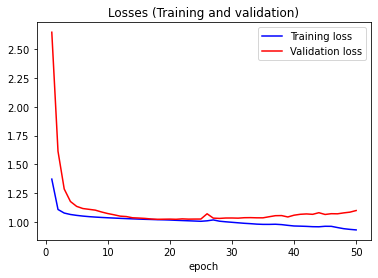

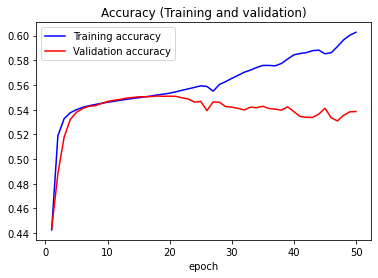

In [139]:
#plot_history_loss(fittedModel.history, ' Feed Forward')
plotLosses(ConvVarModelHistorico.history)
plt.figure()
plotAccuracies(ConvVarModelHistorico.history)


## Estimar o erro e accuracy de teste

In [163]:
#Fazer predict
dirTeste = './Novos Ficheiros/testeAlunos/'

list_npy_filesTeste = glob.glob(dirTeste + '*.npy')
fnames_datasetTeste = tf.data.Dataset.from_tensor_slices(list_npy_filesTeste)

datasetTeste = fnames_datasetTeste.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
batch_size = 1
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Teste = datasetTeste.padded_batch(batch_size, shapes)
loss, accuracy = ConvVariavelModel.evaluate(dataset3Teste)
print("Loss: "+ str(loss))
print("Accuracy: " + str(accuracy))

Cause: could not parse the source code of <function <lambda> at 0x000002A28DBCF8B0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002A28DBCF8B0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, d

## Prever 1 ficheiro individual numpy (DUVIDA: ERRO A PASSAR PARA O PREDICT)

Array de atributos do sinal (a passar para a previsao): [  13.  -17.    7. ... -218. -242. -234.]
1/1 [==============================] - 0s 12ms/step
tf.Tensor([[4 4 4 ... 1 1 1]], shape=(1, 7518), dtype=int64)


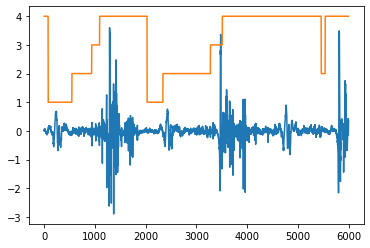

In [143]:
#Fazer predict
def predictNumpyConvolutional(numpyArray):
    transfFourier = tf.math.abs(tf.signal.stft(numpyArray, 64, 32))
    input = (np.array([numpyArray.shape[0]]), np.array([transfFourier]))
    previsao = ConvVariavelModel.predict(input)
    return previsao


#Testar com um ficheiro exemplo (de teste)
filename = "39456_PV_sigTarg.npy"
dirTeste = './Novos Ficheiros/testeAlunos/'
readNumpy = np.load(dirTeste + filename)
atributosSinal = readNumpy[0]
print("Array de atributos do sinal (a passar para a previsao): " +  str(atributosSinal))
previsao = predictNumpyConvolutional(atributosSinal)

previsaoArgMax = tf.argmax(previsao, axis= -1)
print(previsaoArgMax)
plt.plot(atributosSinal[:6000]/2000)
plt.plot(previsaoArgMax[0][:6000])
plt.show()

# Recurrent Network Sinal Variavel

In [55]:
from tensorflow.keras.layers import UpSampling1D, Conv1D, Input, LeakyReLU, LSTM
from tensorflow.keras.models import Model
import glob
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling1D, Conv1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers


def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)



######################################### Validacao ################################
dirValidacao = './Novos Ficheiros/validacaoAlunos/'
list_npy_filesValidacao = glob.glob(dirValidacao + '*.npy')
fnames_datasetValidacao = tf.data.Dataset.from_tensor_slices(list_npy_filesValidacao)
itValidacao = iter(fnames_datasetValidacao)
exValidacao = next(itValidacao)
print(exValidacao)


datasetValidacao = fnames_datasetValidacao.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Validacao = datasetValidacao.padded_batch(batch_size, shapes)
it3Validacao = iter(dataset3Validacao)
ex3Validacao = next(it3Validacao)
print(ex3Validacao)

################################################################################
######################################### Treino ###############################
dirTreino = './Novos Ficheiros/trainAlunos/'
list_npy_filesTreino = glob.glob(dirTreino + '*.npy')
fnames_datasetTreino = tf.data.Dataset.from_tensor_slices(list_npy_filesTreino)
itTreino = iter(fnames_datasetTreino)
exTreino = next(itTreino)
print(exTreino)
datasetTreino = fnames_datasetTreino.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))

batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Treino = datasetTreino.padded_batch(batch_size, shapes)
it3Treino = iter(dataset3Treino)
ex3Treino = next(it3Treino)
print(ex3Treino)

################################################################################
############ Definir modelo ############

#Escalar com o tamanho do sinal
input1Rec = Input(shape=[], name='input1Rec') #L
#Vetor do sinal propriamente dito (da short time fourier transform)
input2Rec = Input(shape=(None, 33) ,name='input2Rec')


layer = Conv1D(32,kernel_size=5, activation='ReLU', padding = "same" )(input2Rec)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)

layer = Conv1D(64,kernel_size=3, activation='ReLU', padding = "same" )(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)

layer = Conv1D(128,kernel_size=5, activation='ReLU', padding = "same" )(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)


layer = LSTM(128,return_sequences=True, recurrent_dropout=0.1)(layer)


p = 35 #35
#7 x 5
layer = TimeDistributed(Dense(p))(layer) #a multiplicacao das ultimas 2 (20,5) tem de ser igual ao da densa
layer = Reshape((-1,5))(layer)


layer = UpSampling1D(size=40)(layer)

L = tf.reduce_max(input1Rec)
L = tf.cast(L, tf.int32)
output = layer[:,:L] #queremos cortar pelo tamanho L para todos os exemplos do batch
layer = Activation("softmax")(output)

recurrentKerasModel = Model(inputs = [input1Rec,input2Rec], outputs = layer)   
recurrentKerasModel.summary()

opt = Adam()
NUM_EPOCHS = 50

from keras.callbacks import EarlyStopping 
early_stopping_monitor = EarlyStopping(patience=50) 

recurrentKerasModel.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=["sparse_categorical_accuracy"])
fittedModel = recurrentKerasModel.fit(dataset3Treino, validation_data = dataset3Validacao, epochs=NUM_EPOCHS, callbacks=[early_stopping_monitor])


tf.Tensor(b'./Novos Ficheiros/validacaoAlunos\\14998_PV_sigTarg.npy', shape=(), dtype=string)
Cause: could not parse the source code of <function <lambda> at 0x000002A27FC048B0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002A27FC048B0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])


KeyboardInterrupt: 

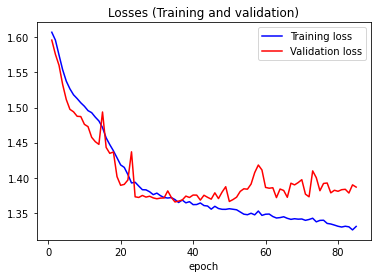

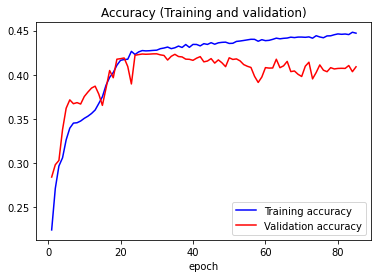

In [ ]:
plotLosses(fittedModel.history)
plt.figure()
plotAccuracies(fittedModel.history)

In [ ]:
#Predict
dirTeste = './Novos Ficheiros/testeAlunos/'

list_npy_filesTeste = glob.glob(dirTeste + '*.npy')
fnames_datasetTeste = tf.data.Dataset.from_tensor_slices(list_npy_filesTeste)

#faz overlap pelo meio para apanhar o que nao conhecemos
#aplicar transformada fourier
datasetTeste = fnames_datasetTeste.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
batch_size = 1
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Teste = datasetTeste.padded_batch(batch_size, shapes)
loss, accuracy = recurrentKerasModel.evaluate(dataset3Teste)
print("Loss: "+ str(loss))
print("Accuracy: " + str(accuracy))

In [ ]:
#Fazer predict
def predictNumpyRecurrent(numpyArray):
    transfFourier = tf.math.abs(tf.signal.stft(numpyArray, 64, 32))
    input = (np.array([numpyArray.shape[0]]), np.array([transfFourier]))
    previsao = recurrentKerasModel.predict(input)
    return previsao


#Testar com um ficheiro exemplo (de teste)
filename = "85077_PV_sigTarg.npy"
dirTeste = './Novos Ficheiros/testeAlunos/'
readNumpy = np.load(dirTeste + filename)
atributosSinal = readNumpy[0]
print("Array de atributos do sinal (a passar para a previsao): " +  str(atributosSinal))
#atributos do sinal (= x[0])
previsao = predictNumpyRecurrent(atributosSinal)
print(previsao)

previsaoArgMax = tf.argmax(previsao, axis=-1)
print(previsaoArgMax.numpy()[0][:5000])
plt.plot(atributosSinal[:2000]/2000)
plt.plot(previsaoArgMax[0][:2000])
plt.show()

# Transformer

In [154]:
from tensorflow.keras.layers import UpSampling1D, Conv1D, Input, LeakyReLU, LSTM
from tensorflow.keras.models import Model
import glob
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv1D,MaxPooling1D, Conv1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, TimeDistributed, SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers


def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

###################################### Validacao #################################
dirValidacao = './Novos Ficheiros/validacaoAlunos/'
list_npy_filesValidacao = glob.glob(dirValidacao + '*.npy')
fnames_datasetValidacao = tf.data.Dataset.from_tensor_slices(list_npy_filesValidacao)


itValidacao = iter(fnames_datasetValidacao)
exValidacao = next(itValidacao)
print(exValidacao)


L = 2000
datasetValidacao = fnames_datasetValidacao.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
#feedforward p segmentar
#rede densa com 2 camadas
#1 saida

batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Validacao = datasetValidacao.padded_batch(batch_size, shapes)
it3Validacao= iter(dataset3Validacao)
ex3Validacao = next(it3Validacao)
print(ex3Validacao)

###############################################################################
###################################### Treino #################################
dirTreino = './Novos Ficheiros/trainAlunos/'
list_npy_filesTreino = glob.glob(dirTreino + '*.npy')
fnames_datasetTreino = tf.data.Dataset.from_tensor_slices(list_npy_filesTreino)


itTreino = iter(fnames_datasetTreino)
exTreino = next(itTreino)
print(exTreino)


L = 2000
datasetTreino = fnames_datasetTreino.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))

batch_size = 128
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Treino = datasetTreino.padded_batch(batch_size, shapes)
it3Treino = iter(dataset3Treino)
ex3Treino = next(it3Treino)
print(ex3Treino)

###############################################################################
#recebe attention que é a informacao de todos os outros
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


#Escalar com o tamanho do sinal
input1Rec = Input(shape=[], name='input1Rec')
#Vetor do sinal propriamente dito (da short time fourier transform)
input2Rec = Input(shape=(None, 33) ,name='input2Rec')


layer = Conv1D(32,kernel_size=5, activation='ReLU', padding = "same" )(input2Rec)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)

layer = Conv1D(64,kernel_size=3, activation='ReLU', padding = "same" )(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)

layer = Conv1D(128,kernel_size=5, activation='ReLU', padding = "same" )(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = SpatialDropout1D(0.1)(layer)


layer = LSTM(128,return_sequences=True, recurrent_dropout=0.1)(layer)



#10
#tamanho do embedding para cada token
embDim = 10
newEmb = layers.TimeDistributed(layers.Dense(embDim))(layer)

inputsPosEmb = PositionEmbedding(maxlen=2000, embed_dim=embDim)(newEmb)
#numheads = 3, ffdim = 8, numheads = numero de attention heads, ffdim = tamanho da camada hidden na ffn dentro do transofrmer
transf1 = TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(inputsPosEmb)
transf2 =TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(transf1)


p = 35
out = layers.TimeDistributed(layers.Dense(p))(transf2)
layer = Reshape((-1,5))(out)

layer = UpSampling1D(size=40)(layer)
L = tf.reduce_max(input1Rec)
L = tf.cast(L, tf.int32)
output = layer[:,:L] #queremos cortar pelo tamanho L para todos os exemplos do batch
layer = Activation("softmax")(output)

transf_model = keras.Model(inputs=[input1Rec, input2Rec], outputs=layer)
transf_model.summary()
NUM_EPOCHS = 100
opt = Adam()

transf_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=["sparse_categorical_accuracy"])
transfPlot = transf_model.fit(dataset3Treino, validation_data = dataset3Validacao, epochs=NUM_EPOCHS)


tf.Tensor(b'./Novos Ficheiros/validacaoAlunos\\14998_PV_sigTarg.npy', shape=(), dtype=string)
Cause: could not parse the source code of <function <lambda> at 0x000002A28D66FD30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002A28D66FD30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])


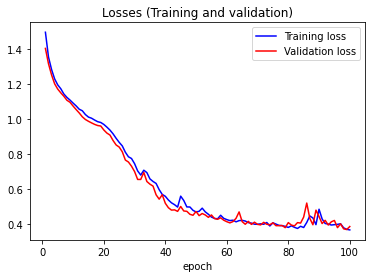

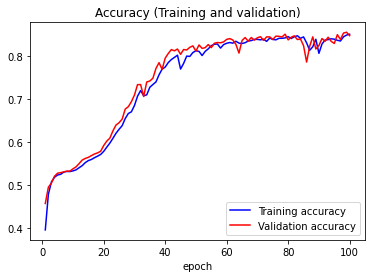

In [158]:
plotLosses(transfPlot.history)
plt.figure()
plotAccuracies(transfPlot.history)

In [159]:
#Fazer previsao
dirTeste = './Novos Ficheiros/testeAlunos/'

list_npy_filesTeste = glob.glob(dirTeste + '*.npy')
fnames_datasetTeste = tf.data.Dataset.from_tensor_slices(list_npy_filesTeste)

#faz overlap pelo meio para apanhar o que nao conhecemos
#aplicar transformada fourier
datasetTeste = fnames_datasetTeste.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32])).map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
batch_size = 1
shapes = (([], tf.TensorShape([None,33])),[None])
dataset3Teste = datasetTeste.padded_batch(batch_size, shapes)
loss, accuracy = transf_model.evaluate(dataset3Teste)
print("Loss: "+ str(loss))
print("Accuracy: " + str(accuracy))

Cause: could not parse the source code of <function <lambda> at 0x000002A288216AF0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002A288216AF0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(x[0], 64, 32))), x[1])

Match 1:
lambda x: tf.numpy_function(read_npy, [x], [tf.float32])

To silence this warning, d

Array de atributos do sinal (a passar para a previsao): [  13.  -17.    7. ... -218. -242. -234.]
1/1 [==============================] - 0s 27ms/step
[[[0.0008812  0.1858758  0.00672974 0.00790214 0.7986111 ]
  [0.0008812  0.1858758  0.00672974 0.00790214 0.7986111 ]
  [0.0008812  0.1858758  0.00672974 0.00790214 0.7986111 ]
  ...
  [0.0008005  0.6424639  0.23280926 0.01358468 0.11034165]
  [0.0008005  0.6424639  0.23280926 0.01358468 0.11034165]
  [0.0008005  0.6424639  0.23280926 0.01358468 0.11034165]]]
tf.Tensor([[4 4 4 ... 1 1 1]], shape=(1, 7518), dtype=int64)


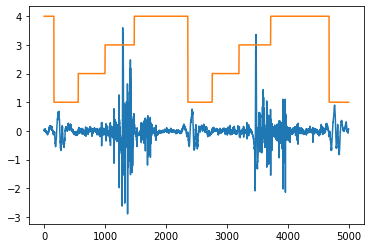

In [162]:
#Fazer predict
def predictNumpyTransf(numpyArray):
    transfFourier = tf.math.abs(tf.signal.stft(numpyArray, 64, 32))
    input = (np.array([numpyArray.shape[0]]), np.array([transfFourier]))
    previsao = transf_model.predict(input)
    return previsao
    # previsao = ConvVariavelModel.predict([tf.shape(transfFourier)[0], dataset3Novo])
    # return previsao


#Testar com um ficheiro exemplo (de teste)
#filename = "50273_PV_sigTarg.npy"
filename = "39456_PV_sigTarg.npy"
dirTeste = './Novos Ficheiros/testeAlunos/'
readNumpy = np.load(dirTeste + filename)
atributosSinal = readNumpy[0]
print("Array de atributos do sinal (a passar para a previsao): " +  str(atributosSinal))
#atributos do sinal (= x[0])
previsao = predictNumpyTransf(atributosSinal)
print(previsao)

previsaoArgMax = tf.argmax(previsao, axis=-1)
print(previsaoArgMax)
plt.plot(atributosSinal[:5000]/2000)
plt.plot(previsaoArgMax[0][:5000])
plt.show()